In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.io       # To import data from .mat file
import timeit
import sys,os
# sys.path.append(r'C:\Users\ssamdani\OneDrive - Farasis Energy Inc\Documents\repos')
sys.path.append(r'../..')


In [2]:
import json
import matplotlib.pyplot as plt
import math

In [3]:
def read_data(flocation, fnames):
    df_list = []
    for fn in fnames:
        df_list.append( pd.read_csv(flocation+ fn +'_interp.csv'))
    return df_list 

In [4]:
def _read_cell_parameters():
    """ initialize cell parameter values for the specified cell """
    with open( ("../../degradation_model/data/cell_data/EVA2.json") ) as f:
        cell_parameters = json.load(f)
    return cell_parameters

class TestInputs:
    
    def __init__(self,cell_parameters, simulation_period_df ):
        self.cell_parameters = cell_parameters
        self.simulation_period_df = simulation_period_df
        self.input_config = dict( lowT_high_SOC_parameter_modifier=1)

In [5]:
def error(x):
    """ error function for optimization
    expects n_test_conditions and inputdf in the current name space
    """
    # Defining parameters
    cellparams['k_cal_ref'] = x[0]
    cellparams['Ea_cal'] = x[1]
    cellparams['alpha'] = x[2]
    cellparams['k0'] = x[3]
    err = np.zeros(n_test_conditions)
    for i in range(n_test_conditions):
        modeldf=pd.DataFrame()
        modeldf[time_col] = inputdf[i]['Time[Hr]'].dropna()
        modeldf[soc_col] = SOC[i]
        modeldf[temp_col] = temp[i]
        modeldf[current_col] = 1 
        model =   DegradationModelECS2018(TestInputs(cellparams, modeldf), "temp",  None)
        model._calendar_loss_calculation()
        loss_model= model.Q_cal
        cap_loss_exp = inputdf[i]['Cap_loss'].values
        err[i] = np.sqrt(np.mean(np.square(loss_model*100 - (100 - cap_loss_exp))))
    return np.sum(err)

In [6]:
%run ../../degradation_model/src/simulation_model.py
time_col, soc_col, temp_col, current_col=  ("Time [hr]", "SOC []", "temp", "Current [A]")

In [7]:
cellparams = _read_cell_parameters()

In [8]:
file_dirc = r'../data/b0_sample/'
file_names =  ['temp-35_soc-80', 'temp-45_soc-100', 'temp-45_soc-60', 'temp-45_soc-80', 'temp-60_soc-100', 'temp-60_soc-60']
# file_names =  ['temp-35_soc-80', 'temp-45_soc-100', 'temp-45_soc-60', 'temp-45_soc-80',  'temp-60_soc-60']
# file_names =  [ 'temp-45_soc-100', 'temp-60_soc-100', 'temp-60_soc-60']
temp = [float(i[5:7]) for i in file_names]
SOC = [float(i[12:])/100 for i in file_names]
n_test_conditions = len(temp) 
inputdf = read_data(file_dirc, file_names)

In [9]:
#%% Optimization function
start = timeit.default_timer()
x0 =  [6.503836857070536756e-04,2.628363630751147866e+04,8.172437818128110154e-02,-6.729983866428148609e-01]
#[3.69e-4,20592,0.384,0.142]
xfinal = opt.fmin(error,x0,maxiter=10000,maxfun = 10000)


stop = timeit.default_timer()
print(f"time required for optimization:{stop - start}")
print(xfinal)

Optimization terminated successfully.
         Current function value: 4.227165
         Iterations: 1574
         Function evaluations: 2598
time required for optimization:51.937860985
[3.22384030e-08 5.88759969e+04 6.23661361e+00 2.12541963e+03]


In [10]:
#%% Optimization function
start = timeit.default_timer()
x0 =  [6.503836857070536756e-04,2.628363630751147866e+04,8.172437818128110154e-02,-6.729983866428148609e-01]
#[3.69e-4,20592,0.384,0.142]
xfinal = opt.fmin(error,x0,maxiter=10000,maxfun = 10000)


stop = timeit.default_timer()
print(f"time required for optimization:{stop - start}")
print(xfinal)

Optimization terminated successfully.
         Current function value: 3.194668
         Iterations: 276
         Function evaluations: 482
5.70033039286118
[1.55530440e-05 6.34916421e+04 1.88977097e+00 2.09863971e+00]


In [12]:
# %% Writing data to csv
np.savetxt(file_dirc+'cal_params_fitted.csv',([[xfinal[0],xfinal[1],xfinal[2],xfinal[3]]]),header = "k_cal_ref,Ea_cal,alpha,k0",
           delimiter = ',',comments = "")

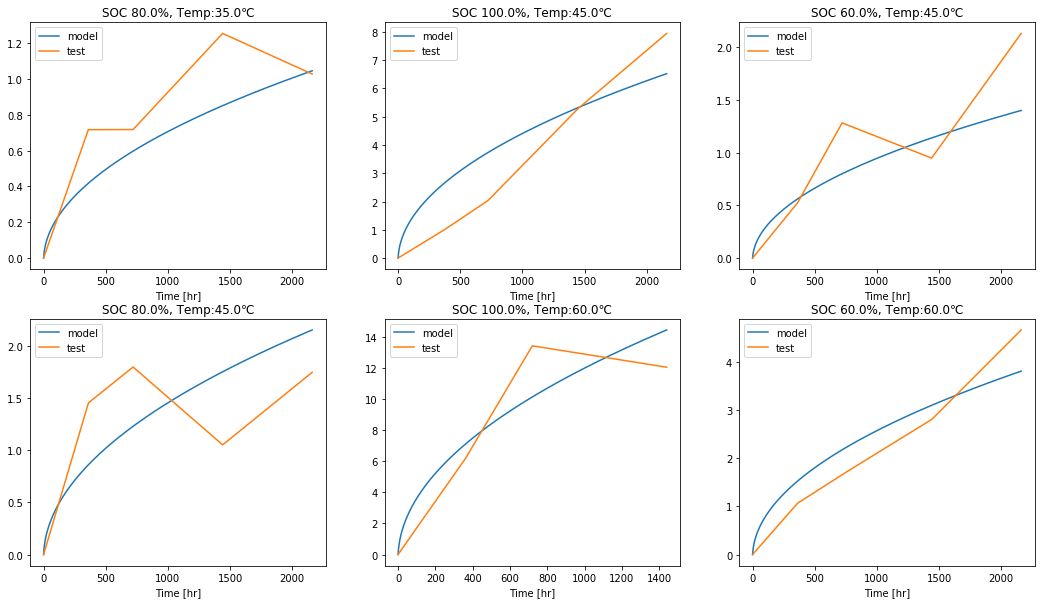

In [19]:
cellparams['k_cal_ref'] = xfinal[0]
cellparams['Ea_cal'] = xfinal[1]
cellparams['alpha'] = xfinal[2]
cellparams['k0'] = xfinal[3]
rows=2
fig,axes_array = plt.subplots(rows, int(math.ceil(n_test_conditions/rows )),figsize=(18,10))
axes = axes_array.flatten()
for i in range(n_test_conditions):
    modeldf=pd.DataFrame()
    modeldf[time_col] = inputdf[i]['Time[Hr]']
    modeldf[soc_col] = SOC[i]
    modeldf[temp_col] = temp[i]
    modeldf[current_col] = 1 
    model =   DegradationModelECS2018(TestInputs(cellparams, modeldf), "temp", None)
    model._calendar_loss_calculation()
    loss_model= model.Q_cal
    cap_loss_exp = inputdf[i]['Cap_loss'].values
    modeldf['model'] = loss_model* 100
    modeldf['exp'] = 100- cap_loss_exp 
    modeldf.plot(x=time_col, y='model',ax=axes[i], label='model', )
    modeldf.plot(x=time_col, y='exp',ax=axes[i],  xlabel = label='test',  title=f"SOC {SOC[i]*100}%, Temp:{temp[i]}℃")

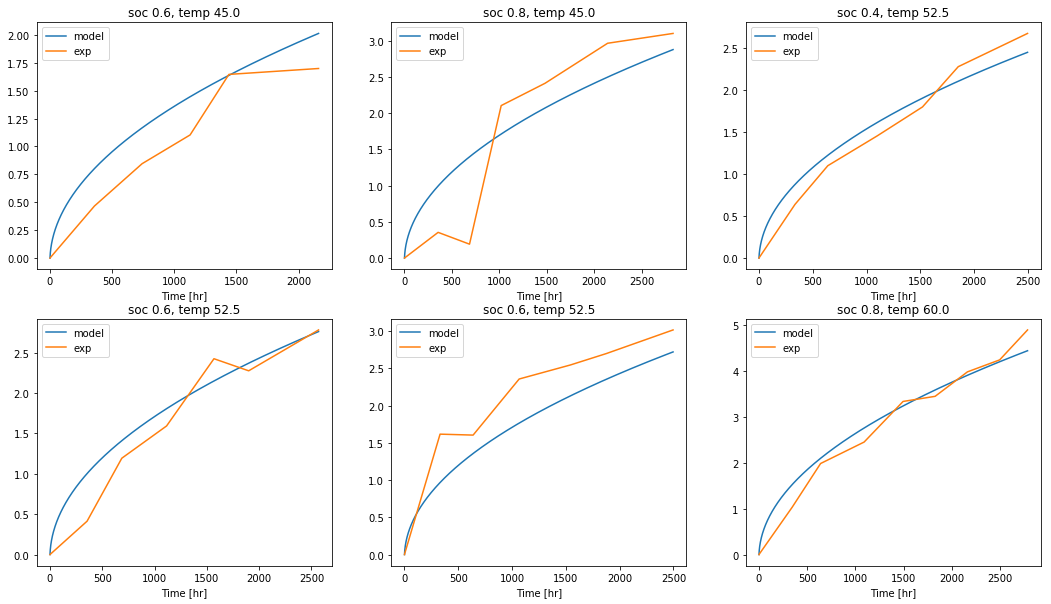

In [55]:
#previous results

In [29]:
x_sj = np.array([6.503836857070536756e-04,2.628363630751147866e+04,8.172437818128110154e-02,-6.729983866428148609e-01])
print(error(x_sj))

setting first time stamp to non zero
setting first time stamp to non zero
setting first time stamp to non zero
setting first time stamp to non zero
setting first time stamp to non zero
setting first time stamp to non zero
1.891415972940464
